In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from prettytable import PrettyTable
from scipy.stats import chi2_contingency
from scipy.stats import shapiro, ttest_rel, wilcoxon, mannwhitneyu, ttest_ind
import wordcloud

In [2]:
df = pd.read_csv("P1_experiment_logs.csv")
df['Uncertainties'] = df['Uncertainties'].apply(ast.literal_eval)

df.style.format({
}).set_properties(**{
    'text-align': 'center',
    'border': '1px solid black'
}).set_table_styles([
    dict(selector='th', props=[('text-align', 'center')]),
    dict(selector='th', props=[('background-color', '#f7f7f9')]),
    dict(selector='td', props=[('padding', '6px')])
])

,Participant Code,Condition,Task,Uncertainties,Selected Starting State,Selected State Uncertainty,Selected State Category,Uncertainty Categories
0,p1,blind,Phase1TaskLeft,"[5.858858906956926, 4.371270820246574, 4.44961857404317, 5.148377584658761, 4.571846943865117, 4.157613235105198, 3.4732849804833044, 2.5937287133970575, 2.3332533680260843, 2.387176048047101]",9,2.387176,Expected Failure,"['Highly Unexpected Success', 'Unexpected Success', 'Unexpected Success', 'Highly Unexpected Success', 'Unexpected Success', 'Unexpected Failure', 'Unexpected Failure', 'Unexpected Failure', 'Expected Failure', 'Expected Failure']"
1,p1,blind,Phase1TaskLeft,"[5.550994609899847, 4.257239349951271, 4.18302924112391, 5.078376426238713, 5.212879131126933, 5.9900745252682, 3.186260864646182, 2.5664827494506817, 2.3020022487064993, 2.0357252165391837]",8,2.302002,Expected Failure,"['Highly Unexpected Success', 'Unexpected Success', 'Unexpected Success', 'Unexpected Failure', 'Unexpected Success', 'Highly Unexpected Success', 'Unexpected Failure', 'Unexpected Failure', 'Expected Failure', 'Expected Failure']"
2,p1,blind,Phase1TaskLeft,"[5.319908017717525, 4.701746194549301, 4.284823535542397, 4.712970146628436, 4.989524172827038, 6.628622307047623, 2.8579502514185506, 2.2781320845823583, 1.7711415393115622, 2.2319182740057752]",7,2.278132,Unexpected Failure,"['Highly Unexpected Success', 'Unexpected Success', 'Unexpected Success', 'Unexpected Success', 'Unexpected Success', 'Highly Unexpected Failure', 'Unexpected Failure', 'Unexpected Failure', 'Expected Failure', 'Expected Failure']"
3,p1,blind,Phase1TaskLeft,"[4.449368703398184, 4.3603530874126415, 4.292530309741646, 5.16751860173757, 6.060767330418458, 5.420509871268313, 3.217596116432788, 3.080502836499325, 2.8302572564079154, 2.7023582974175886]",8,2.830257,Expected Failure,"['Unexpected Failure', 'Unexpected Success', 'Unexpected Success', 'Unexpected Failure', 'Highly Unexpected Failure', 'Highly Unexpected Failure', 'Unexpected Failure', 'Unexpected Failure', 'Expected Failure', 'Expected Failure']"
4,p1,blind,Phase1TaskLeft,"[4.484140905053232, 5.292951503666044, 5.073794101496313, 5.611141336137832, 6.138499616010063, 5.434685360533819, 3.772594168394454, 2.3950650856425626, 1.9917739661534246, 1.7039965879021353]",7,2.395065,Unexpected Failure,"['Unexpected Failure', 'Unexpected Success', 'Unexpected Success', 'Highly Unexpected Success', 'Highly Unexpected Failure', 'Unexpected Success', 'Unexpected Failure', 'Unexpected Failure', 'Expected Failure', 'Expected Failure']"
5,p1,visible,Phase1TaskLeft,"[5.378626661831089, 4.990856954598903, 4.451181298577448, 4.697146171579774, 5.047416178889375, 3.8413633665215645, 3.5827682834689565, 2.8343174034657688, 2.8005814053406257, 2.3127295429299517]",4,5.047416,Highly Unexpected Success,"['Highly Unexpected Success', 'Unexpected Success', 'Unexpected Success', 'Unexpected Success', 'Highly Unexpected Success', 'Unexpected Failure', 'Unexpected Failure', 'Unexpected Failure', 'Expected Failure', 'Expected Failure']"
6,p1,visible,Phase1TaskLeft,"[5.75622829264735, 4.577373043348945, 4.54653783967821, 5.828724851372043, 4.683454924942828, 6.197527477696029, 3.309425421140594, 2.178178680539742, 2.7874571349481636, 2.759554103851337]",5,6.197527,Highly Unexpected Success,"['Unexpected Success', 'Unexpected Success', 'Unexpected Failure', 'Highly Unexpected Success', 'Unexpected Success', 'Highly Unexpected Success', 'Unexpected Failure', 'Expected Failure', 'Unexpected Failure', 'Expected Failure']"
7,p1,visible,Phase1TaskLeft,"[3.6840108230761355, 5.526475240186361, 4.667012111099342, 4.733915148490341, 5.12318317253394, 4.225106063330556, 3.4549498635604823, 2.728212211474585, 2.423971580303922, 1.4923693493744348]",4,5.123183,Highly Unexpected Failure,"['Unexpected Failure', 'Highly Unexpected Success', 'Unexpected Success', 'Unexpected Failure', 'Highly Unexpected Failure', 'Unexpected Failure', 'Unexpected Failure', 'Unexpected Failure', 'E

# notes

- open ended question( how did you interpret the numbers) what do they mean to you? 
- how did you make decision strategy for selection of start states. 
- do you have suggestions on presenting the info (uncertainties) 
- what info would you like to know? anything extra to show? 

- If there was a fancier robot, what would you like it to show? (multi choice) + please explain your choice
- how active do you want the robot in asking/providing uncertanties 

secondary reader.

gift cards

- 

# NOTES 09/10



# DATA ANALYSIS

In [5]:

data_files = ['P1_experiment_logs.csv', 'P2_experiment_logs.csv', 'P3_experiment_logs.csv', 'P4_experiment_logs.csv', 'P5_experiment_logs.csv', 'P6_experiment_logs.csv', 'P7_experiment_logs.csv', 'P8_experiment_logs.csv', 'P9_experiment_logs.csv', 'P10_experiment_logs.csv', 'P11_experiment_logs.csv', 'P12_experiment_logs.csv']

# Read and concatenate all data files
data_list = []
for file in data_files:
    df = pd.read_csv(file)
    data_list.append(df)


data = pd.concat(data_list, ignore_index=True)

data['Uncertainties'] = data['Uncertainties'].apply(ast.literal_eval)
data['Uncertainty Categories'] = data['Uncertainty Categories'].apply(ast.literal_eval)

# Ensure 'Selected State Uncertainty' is numeric
data['Selected State Uncertainty'] = pd.to_numeric(data['Selected State Uncertainty'])


Mann-Whitney U test: U-statistic = 76.0, p-value = 0.8271190942320861


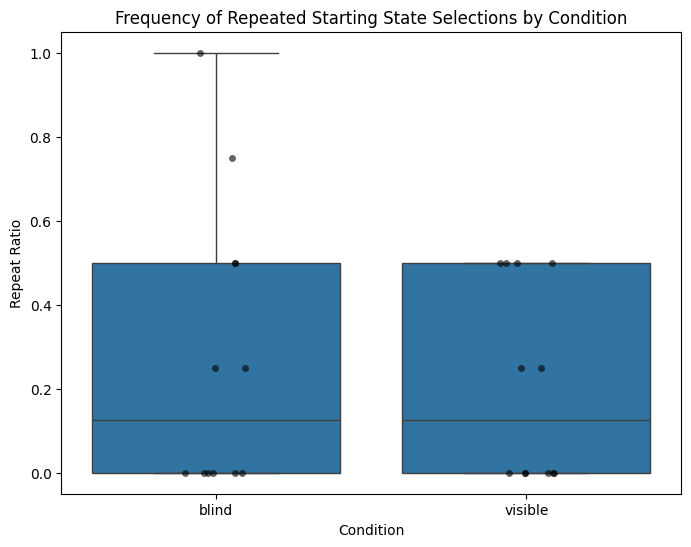

In [6]:
# Add a 'Trial' column to keep track of trial order
data['Trial'] = data.groupby(['Participant Code', 'Condition']).cumcount()

# Calculate repeat frequencies
repeat_counts = []

participants = data['Participant Code'].unique()

for participant in participants:
    participant_data = data[data['Participant Code'] == participant]
    
    for condition in ['blind', 'visible']:
        condition_data = participant_data[participant_data['Condition'] == condition]
        
        # Ensure data is sorted by trial
        condition_data = condition_data.sort_values(by='Trial').reset_index()
        
        # Check for repeated selections (same starting state as the previous trial)
        repeated_selections = (condition_data['Selected Starting State'] == condition_data['Selected Starting State'].shift(1))
        repeat_count = repeated_selections.sum()  # Total number of repeats
        total_trials = len(condition_data) - 1  # Exclude the first trial (no previous trial to compare)
        repeat_ratio = repeat_count / total_trials if total_trials > 0 else 0  # Avoid division by zero
        
        repeat_counts.append({
            'Participant': participant,
            'Condition': condition,
            'Repeat Ratio': repeat_ratio
        })

# Create a DataFrame for repeat ratios
repeat_df = pd.DataFrame(repeat_counts)

# Compare repeat ratios between conditions
blind_repeats = repeat_df[repeat_df['Condition'] == 'blind']['Repeat Ratio']
visible_repeats = repeat_df[repeat_df['Condition'] == 'visible']['Repeat Ratio']

# Check for normality
blind_normality = shapiro(blind_repeats)
visible_normality = shapiro(visible_repeats)

if blind_normality.pvalue > 0.05 and visible_normality.pvalue > 0.05:
    # Data is normally distributed, perform t-test
    t_stat, t_pvalue = ttest_ind(blind_repeats, visible_repeats)
    print(f"Independent t-test: t-statistic = {t_stat}, p-value = {t_pvalue}")
else:
    # Data is not normally distributed, perform Mann-Whitney U test
    u_stat, u_pvalue = mannwhitneyu(blind_repeats, visible_repeats)
    print(f"Mann-Whitney U test: U-statistic = {u_stat}, p-value = {u_pvalue}")

# Visualize repeat ratios by condition
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.boxplot(x='Condition', y='Repeat Ratio', data=repeat_df)
sns.stripplot(x='Condition', y='Repeat Ratio', data=repeat_df, color='black', alpha=0.6, jitter=True)
plt.title('Frequency of Repeated Starting State Selections by Condition')
plt.xlabel('Condition')
plt.ylabel('Repeat Ratio')
plt.show()

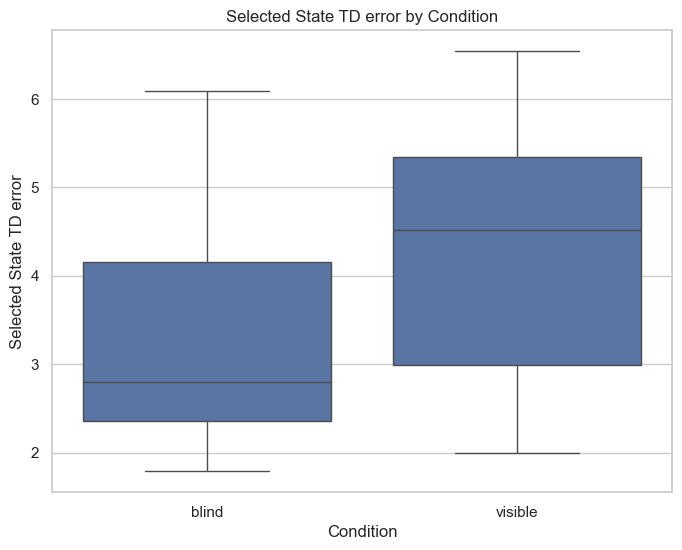

In [7]:
sns.set(style='whitegrid')

# Boxplot of Selected State Uncertainty by Condition
plt.figure(figsize=(8, 6))
sns.boxplot(x='Condition', y='Selected State Uncertainty', data=data)
plt.title('Selected State TD error by Condition')
plt.xlabel('Condition')
plt.ylabel('Selected State TD error')
plt.show()

In [8]:
# TESTING TO SEE IF VISIBLE CONDITION SELECTED HIGHER TD ERROR VALUES:
blind_data = data[data['Condition'] == 'blind']['Selected State Uncertainty']
visible_data = data[data['Condition'] == 'visible']['Selected State Uncertainty']

shapiro_blind = shapiro(blind_data)
shapiro_visible = shapiro(visible_data)

print(f"Shapiro-Wilk test for blind condition: p-value = {shapiro_blind.pvalue}")
print(f"Shapiro-Wilk test for visible condition: p-value = {shapiro_visible.pvalue}")

if shapiro_blind.pvalue < 0.05 or shapiro_visible.pvalue < 0.05:
    # Perform Wilcoxon signed-rank test
    stat, p_value = wilcoxon(blind_data, visible_data)
    print(f"Wilcoxon signed-rank test: p-value = {p_value}")
else:
    # Perform paired t-test
    stat, p_value = ttest_rel(blind_data, visible_data)
    print(f"Paired t-test: p-value = {p_value}")

print("\nParticipants in “visible” condition selected states with higher TD errors compared to those in blind condition. \nTherefore, visualisation of robot expectation influenced participants to select states with higher TD error values. ")

Shapiro-Wilk test for blind condition: p-value = 1.2619639524150617e-05
Shapiro-Wilk test for visible condition: p-value = 0.0017256049019908901
Wilcoxon signed-rank test: p-value = 0.0003465791905709803

Participants in “visible” condition selected states with higher TD errors compared to those in blind condition. 
Therefore, visualisation of robot expectation influenced participants to select states with higher TD error values. 


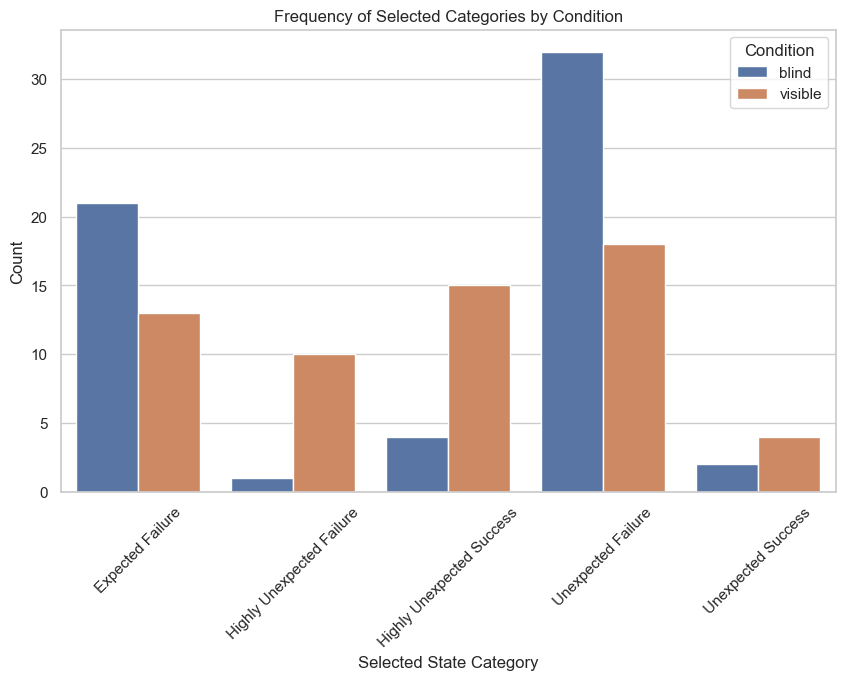

In [9]:
selected_categories = data[['Condition', 'Selected State Category']]

# Count the frequencies
category_counts = selected_categories.groupby(['Condition', 'Selected State Category']).size().reset_index(name='Count')

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Selected State Category', y='Count', hue='Condition', data=category_counts)
plt.title('Frequency of Selected Categories by Condition')
plt.xlabel('Selected State Category')
plt.ylabel('Count')
plt.legend(title='Condition')
plt.xticks(rotation=45)
plt.show()

In [10]:
data['Highly Unexpected'] = data['Selected State Category'].isin(['Highly Unexpected Failure', 'Highly Unexpected Success'])
contingency_table = pd.crosstab(data['Condition'], data['Highly Unexpected'])
# chi-square test of independence
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-square statistic = {chi2_stat}")
print(f"p-value = {p_value}")
print(f"Degrees of freedom = {dof}")
print("Expected frequencies:")
print(expected)

Chi-square statistic = 16.044444444444444
p-value = 6.187289775861156e-05
Degrees of freedom = 1
Expected frequencies:
[[45. 15.]
 [45. 15.]]


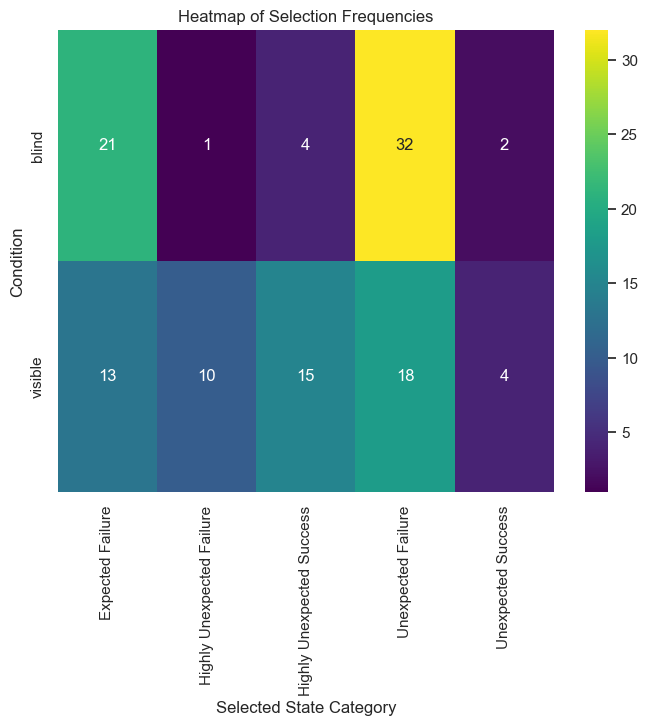

In [11]:
pivot_table = category_counts.pivot(index='Condition', columns='Selected State Category', values='Count').fillna(0)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True, fmt='g', cmap='viridis')
plt.title('Heatmap of Selection Frequencies')
plt.xlabel('Selected State Category')
plt.ylabel('Condition')
plt.show()

In [12]:
participant_data = data[data['Participant Code'] == 'p3']

# Add a trial number for plotting
participant_data = participant_data.reset_index().rename(columns={'index': 'Trial'})

# Plot selected state uncertainty over trials for each condition
plt.figure(figsize=(12, 6))
sns.lineplot(x='Trial', y='Selected State Uncertainty', hue='Condition', data=participant_data, marker='o')
plt.title('Participant p3: Selected State Uncertainty Over Trials')
plt.xlabel('Trial')
plt.ylabel('Selected State Uncertainty')
plt.legend(title='Condition')
plt.show()

ValueError: Data must be 1-dimensional, got ndarray of shape (10, 2) instead

<Figure size 1200x600 with 0 Axes>

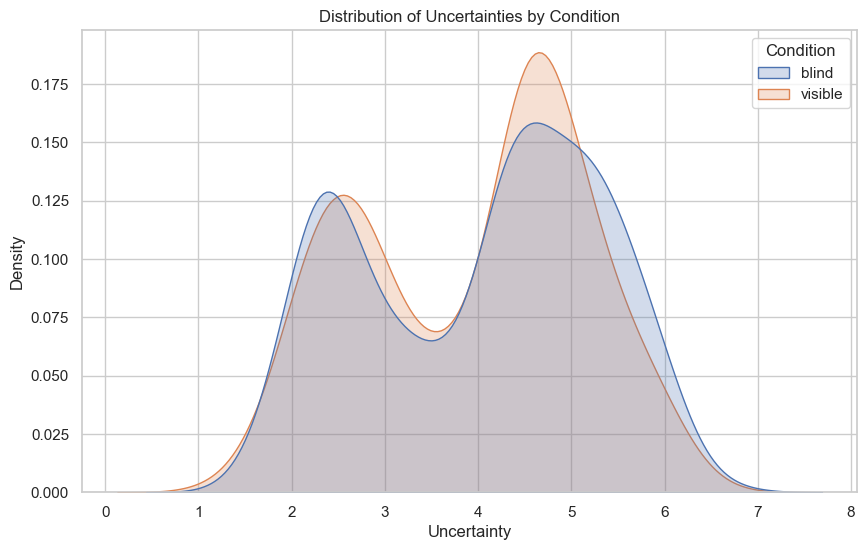

In [13]:
uncertainty_records = []

for idx, row in data.iterrows():
    uncertainties = row['Uncertainties']
    categories = row['Uncertainty Categories']
    for u, c in zip(uncertainties, categories):
        uncertainty_records.append({
            'Participant Code': row['Participant Code'],
            'Condition': row['Condition'],
            'Uncertainty': u,
            'Category': c
        })

uncertainty_df = pd.DataFrame(uncertainty_records)

# Plot distribution
plt.figure(figsize=(10, 6))
sns.kdeplot(x='Uncertainty', hue='Condition', data=uncertainty_df, fill=True)
plt.title('Distribution of Uncertainties by Condition')
plt.xlabel('Uncertainty')
plt.ylabel('Density')
plt.show()

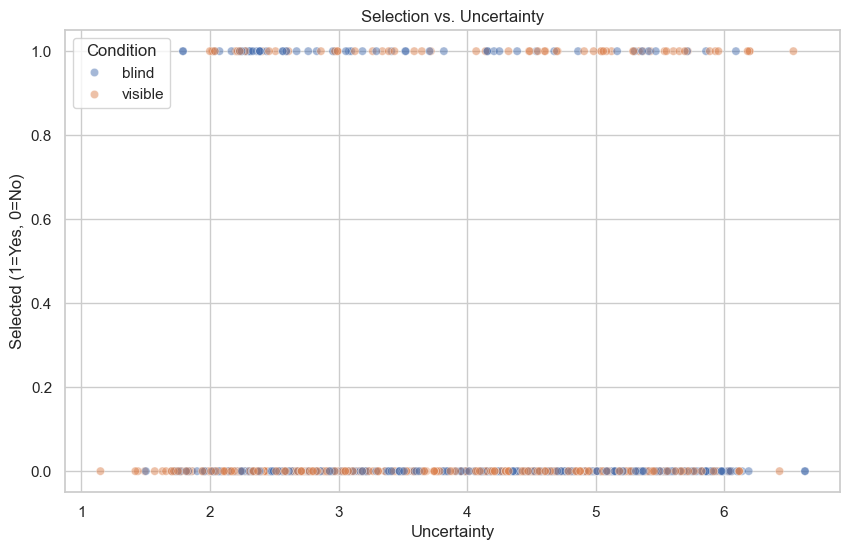

In [14]:
# For each trial, mark the selected starting state
selection_records = []

for idx, row in data.iterrows():
    uncertainties = row['Uncertainties']
    selected_state = row['Selected Starting State']
    for state_idx, uncertainty in enumerate(uncertainties):
        selection_records.append({
            'Participant Code': row['Participant Code'],
            'Condition': row['Condition'],
            'Trial': idx,
            'Starting State': state_idx,
            'Uncertainty': uncertainty,
            'Selected': 1 if state_idx == selected_state else 0
        })

selection_df = pd.DataFrame(selection_records)

# Plot probability of selection vs. uncertainty
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Uncertainty', y='Selected', hue='Condition', data=selection_df, alpha=0.5)
plt.title('Selection vs. Uncertainty')
plt.xlabel('Uncertainty')
plt.ylabel('Selected (1=Yes, 0=No)')
plt.legend(title='Condition')
plt.show()

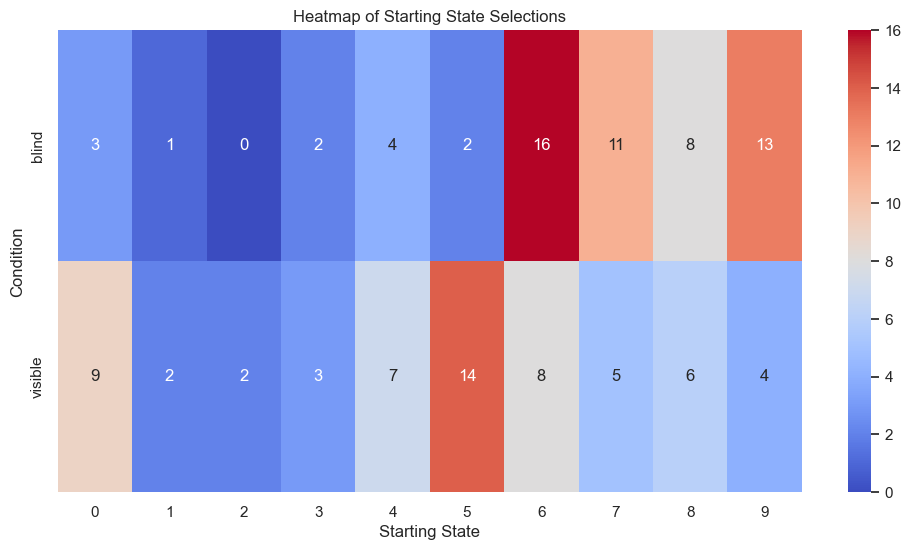

In [16]:
# Count selections of each starting state
state_selection_counts = selection_df[selection_df['Selected'] == 1].groupby(['Condition', 'Starting State']).size().reset_index(name='Count')

# Pivot for heatmap
state_pivot = state_selection_counts.pivot(index='Condition', columns='Starting State', values='Count').fillna(0)

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(state_pivot, annot=True, fmt='g', cmap='coolwarm')
plt.title('Heatmap of Starting State Selections')
plt.xlabel('Starting State')
plt.ylabel('Condition')
plt.show()

In [19]:
# For each trial, mark the selected starting state and transfer all relevant columns
selection_records = []

for idx, row in data.iterrows():
    uncertainties = row['Uncertainties']
    selected_state = row['Selected Starting State']
    for state_idx, uncertainty in enumerate(uncertainties):
        selection_records.append({
            'Participant Code': row['Participant Code'],
            'Condition': row['Condition'],
            'Trial': idx,
            'Starting State': state_idx,
            'Uncertainty': uncertainty,
            'Selected': 1 if state_idx == selected_state else 0,
            'Selected Starting State': selected_state,  # Transfer this column
            'Selected State Uncertainty': row['Selected State Uncertainty'],  # Ensure correct transfer
            'Selected State Category': row['Selected State Category'],  # Transfer as needed
        })

selection_df = pd.DataFrame(selection_records)

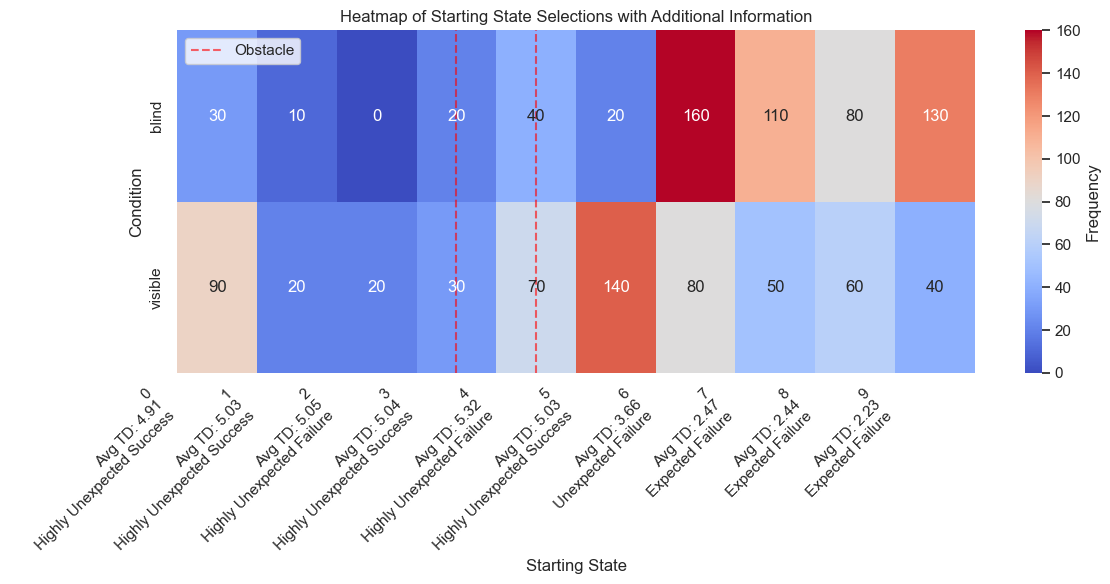

In [20]:
# Calculate the average uncertainty per starting state and condition
td_error_avg = (
    selection_df.groupby(['Condition', 'Selected Starting State'])['Selected State Uncertainty']
    .mean()
    .reset_index()
)
td_error_avg.rename(columns={'Selected State Uncertainty': 'Average TD Error'}, inplace=True)

# Determine the most common category for each starting state
most_common_category = (
    selection_df.groupby(['Condition', 'Selected Starting State'])['Selected State Category']
    .agg(lambda x: x.mode()[0] if not x.mode().empty else "N/A")
    .reset_index()
)
most_common_category.rename(columns={'Selected State Category': 'Most Common Category'}, inplace=True)

# Merge the data with average TD error
state_summary = pd.merge(td_error_avg, most_common_category, on=['Condition', 'Selected Starting State'])

# Count selections of each starting state
state_selection_counts = (
    selection_df.groupby(['Condition', 'Selected Starting State'])
    .size()
    .reset_index(name='Count')
)

# Pivot for heatmap
state_pivot = state_selection_counts.pivot(index='Condition', columns='Selected Starting State', values='Count').fillna(0)

# Generate custom labels for the x-axis
custom_labels = []
for state in sorted(selection_df['Selected Starting State'].unique()):
    avg_td = state_summary[state_summary['Selected Starting State'] == state]['Average TD Error'].mean()
    category = state_summary[state_summary['Selected Starting State'] == state]['Most Common Category'].mode()[0]
    custom_labels.append(f"{state}\nAvg TD: {avg_td:.2f}\n{category}")

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(state_pivot, annot=True, fmt='g', cmap='coolwarm', cbar_kws={'label': 'Frequency'})
plt.title('Heatmap of Starting State Selections with Additional Information')
plt.xlabel('Starting State')
plt.ylabel('Condition')
plt.xticks(ticks=range(len(custom_labels)), labels=custom_labels, rotation=45, ha='right')

# Highlight obstacles (states 4 and 5)
plt.axvline(x=3.5, color='red', linestyle='--', alpha=0.6, label='Obstacle')
plt.axvline(x=4.5, color='red', linestyle='--', alpha=0.6)

# Add legend
plt.legend(loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
# Map categories to numeric codes for plotting
category_mapping = {'Highly Unexpected Success': 5, 'Highly Unexpected Failure': 6,
                    'Unexpected Success': 3, 'Unexpected Failure': 4,
                    'Expected Success': 1, 'Expected Failure': 2}

data['Selected Category Code'] = data['Selected State Category'].map(category_mapping)

# Plot over trials
plt.figure(figsize=(12, 6))
sns.lineplot(x=data.index, y='Selected Category Code', hue='Condition', data=data, marker='o')
plt.title('Selected State Categories')
plt.xlabel('Trial')
plt.ylabel('Category')
plt.yticks([1, 2, 3, 4, 5, 6], ['Expected Success', 'Expected Failure', 'Unexpected Success', 'Unexpected Failure', 'Highly Unexpected Success', 'Highly Unexpected Failure'])
plt.legend(title='Condition')
plt.show()

In [ ]:
# Assuming participants experience both conditions
participants = data['Participant Code'].unique()

for participant in participants:
    participant_data = data[data['Participant Code'] == participant]
    participant_data = participant_data.reset_index().rename(columns={'index': 'Trial'})
    
    plt.figure(figsize=(12, 6))
    sns.lineplot(x='Trial', y='Selected Category Code', hue='Condition', data=participant_data, marker='o')
    plt.title(f'Participant {participant}: Strategy Switching Between Conditions')
    plt.xlabel('Trial')
    plt.ylabel('Category Code (1=Expected, 2=Unexpected, 3=Highly Unexpected)')
    plt.yticks([1, 2, 3], ['Expected', 'Unexpected', 'Highly Unexpected'])
    plt.legend(title='Condition')
    plt.show()

In [ ]:
participants = data['Participant Code'].unique()

strategy_changes = []

for participant in participants:
    participant_data = data[data['Participant Code'] == participant]
    participant_data = participant_data.reset_index().rename(columns={'index': 'Trial'})
    
    # Calculate strategy changes for each condition
    for condition in ['blind', 'visible']:
        condition_data = participant_data[participant_data['Condition'] == condition]
        condition_data = condition_data.sort_values(by='Trial')
        
        # Count the number of strategy changes
        # Only count when the 'Selected Category Code' changes (ignore when it stays the same)
        strategy_change_count = (condition_data['Selected Category Code'].diff().fillna(0) != 0).sum()
        
        # Append results for this participant and condition
        strategy_changes.append({
            'Participant': participant,
            'Condition': condition,
            'Strategy Changes': strategy_change_count
        })

# Create a DataFrame to store the strategy change counts
strategy_change_df = pd.DataFrame(strategy_changes)

# Plot the strategy change counts for each condition per participant
plt.figure(figsize=(10, 6))
sns.barplot(x='Participant', y='Strategy Changes', hue='Condition', data=strategy_change_df)
plt.title('Strategy Changes Between Blind and Visible Conditions')
plt.xlabel('Participant')
plt.ylabel('Number of Strategy Changes')
plt.show()

In [ ]:
# Split data by condition
blind_changes = strategy_change_df[strategy_change_df['Condition'] == 'blind']['Strategy Changes']
visible_changes = strategy_change_df[strategy_change_df['Condition'] == 'visible']['Strategy Changes']

# Step 1: Check for normality using Shapiro-Wilk test
blind_normality = shapiro(blind_changes)
visible_normality = shapiro(visible_changes)

print(f"Shapiro-Wilk test for 'blind' condition: p-value = {blind_normality.pvalue}")
print(f"Shapiro-Wilk test for 'visible' condition: p-value = {visible_normality.pvalue}")

if blind_normality.pvalue > 0.05 and visible_normality.pvalue > 0.05:
    # Data is normally distributed, perform paired t-test
    t_stat, t_pvalue = ttest_rel(blind_changes, visible_changes)
    print(f"Paired t-test: t-statistic = {t_stat}, p-value = {t_pvalue}")
else:
    # Data is not normally distributed, perform Wilcoxon signed-rank test
    wilcoxon_stat, wilcoxon_pvalue = wilcoxon(blind_changes, visible_changes)
    print(f"Wilcoxon signed-rank test: statistic = {wilcoxon_stat}, p-value = {wilcoxon_pvalue}")


In [ ]:
# Example: Boxplots of Uncertainties and Frequencies Side by Side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Boxplot
sns.boxplot(x='Condition', y='Selected State TD error', data=data, ax=axes[0])
axes[0].set_title('Selected State TD error by Condition')
axes[0].set_xlabel('Condition')
axes[0].set_ylabel('Selected State TD error')

# Bar plot
sns.countplot(x='Selected State Category', hue='Condition', data=data, ax=axes[1])
axes[1].set_title('Frequency of Selected Categories by Condition')
axes[1].set_xlabel('Selected State Category')
axes[1].set_ylabel('Count')
axes[1].legend(title='Condition')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Merged data with logs and excel

In [ ]:
experiment_logs_df = pd.concat(data_list, ignore_index=True)

experiment_logs_df['Uncertainties'] = experiment_logs_df['Uncertainties'].apply(ast.literal_eval)
experiment_logs_df['Uncertainty Categories'] = experiment_logs_df['Uncertainty Categories'].apply(ast.literal_eval)
experiment_logs_df['Selected State Uncertainty'] = pd.to_numeric(experiment_logs_df['Selected State Uncertainty'])

questionnaire_df = pd.read_excel('Questionnaire (Responses).xlsx')
demographics_df = pd.read_excel('Demographic information (Responses).xlsx')

merged_df = pd.merge(questionnaire_df, demographics_df, on='Your Subject ID', how='inner')

merged_full_df = pd.merge(experiment_logs_df, merged_df, left_on='Participant Code', right_on='Your Subject ID', how='inner')

# merged_full_df.style.format({
# }).set_properties(**{
#     'text-align': 'center',
#     'border': '1px solid black'
# }).set_table_styles([
#     dict(selector='th', props=[('text-align', 'center')]),
#     dict(selector='th', props=[('background-color', '#f7f7f9')]),
#     dict(selector='td', props=[('padding', '6px')])
# ])

# Looking and demographic and questionnaire specific information

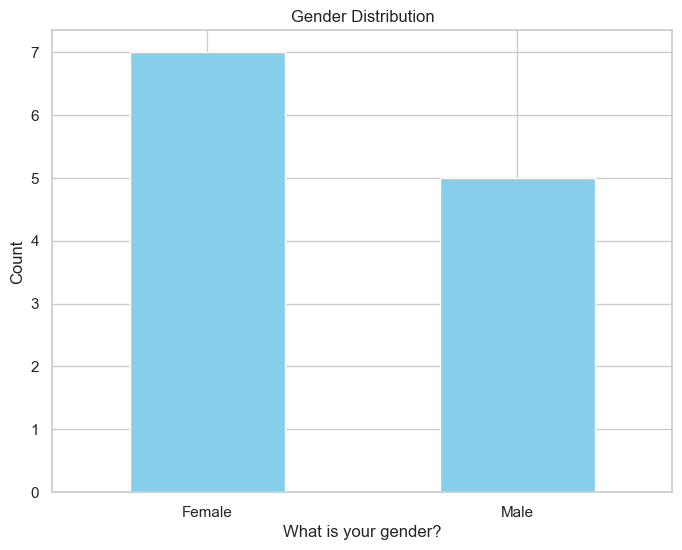

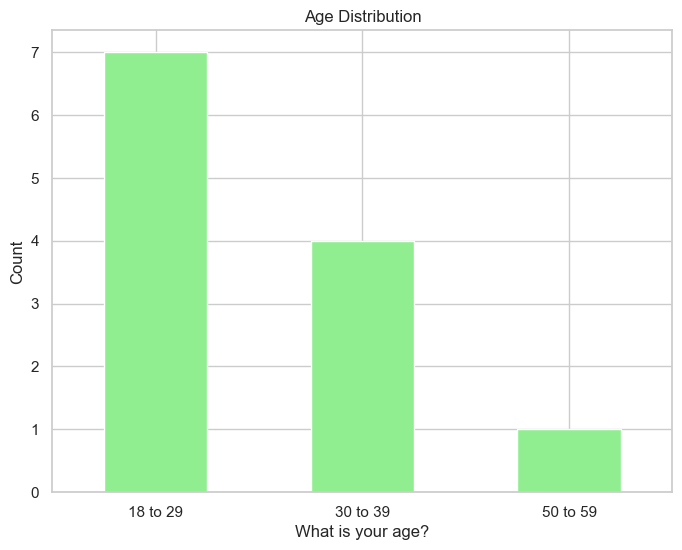

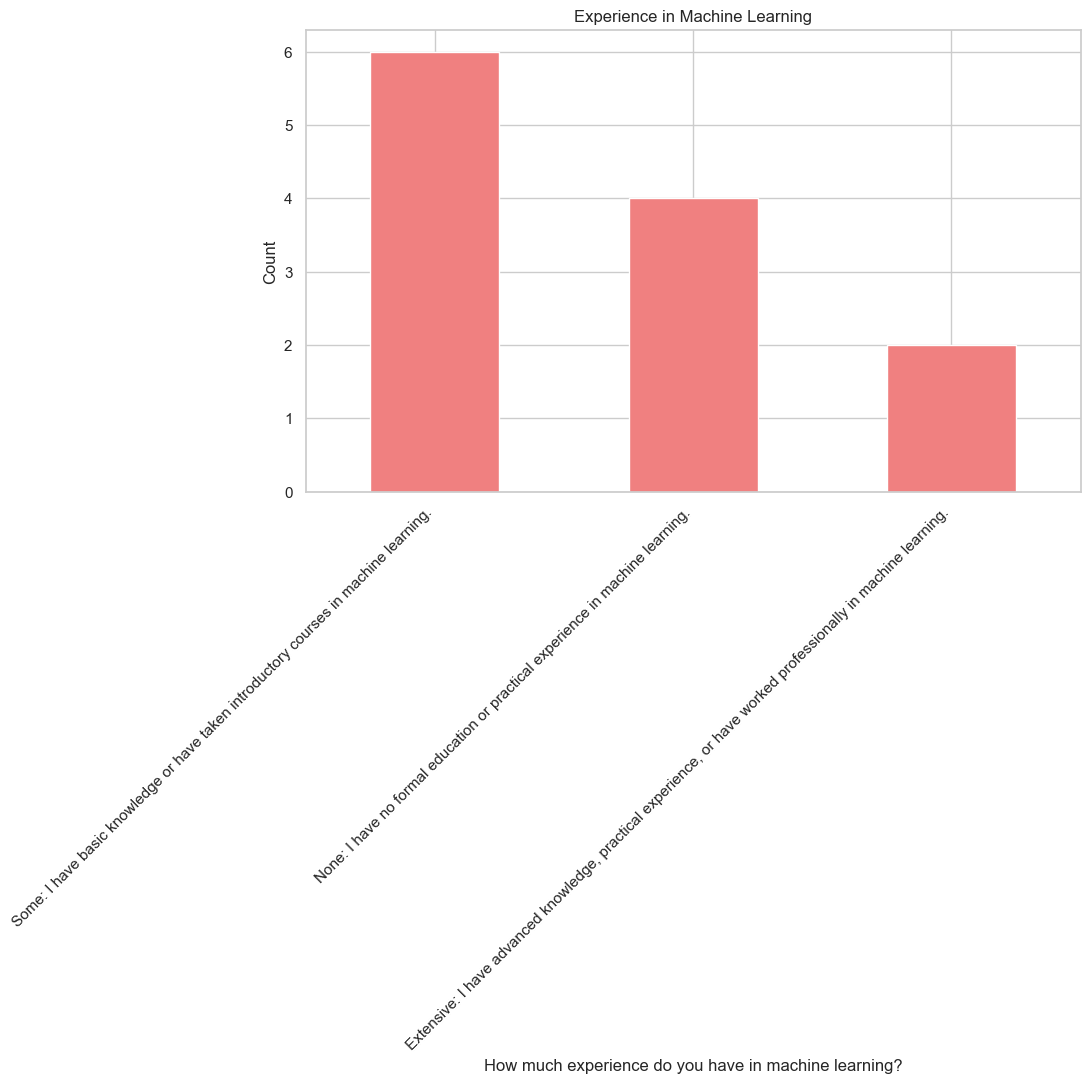

In [21]:
questionnaire_data = pd.read_excel('Questionnaire (Responses).xlsx')
demographic_data = pd.read_excel('Demographic information (Responses).xlsx')

demographic_data.columns = demographic_data.columns.str.strip()

gender_distribution = demographic_data['What is your gender?'].value_counts()
age_distribution = demographic_data['What is your age?'].value_counts()
experience_distribution = demographic_data['How much experience do you have in machine learning?'].value_counts()
color_blindness_distribution = demographic_data['Do you have any form of color blindness?'].value_counts()

gender_distribution, age_distribution, experience_distribution, color_blindness_distribution

# Plot gender distribution
plt.figure(figsize=(8, 6))
gender_distribution.plot(kind='bar', color='skyblue')
plt.title('Gender Distribution')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

# Plot age distribution
plt.figure(figsize=(8, 6))
age_distribution.plot(kind='bar', color='lightgreen')
plt.title('Age Distribution')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

# Plot experience in machine learning
plt.figure(figsize=(10, 6))
experience_distribution.plot(kind='bar', color='lightcoral')
plt.title('Experience in Machine Learning')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()



# Analysing first and second open ended question (Strategy in part 1 and in part 2)

In [22]:
strat_blind_cond = pd.read_csv("Strategy_Categorization_Blind_Condition.csv")
strat_blind_cond

,Response,Strategy
0,I wanted to select starting states where the r...,Failure-driven strategy
1,The states where the robot arm failed during t...,Failure-driven strategy
2,I chose starting positions near the red block ...,Difficulty-based strategy
3,choose the position I think is the most diffic...,Failure-driven strategy
4,1. by the state that failed the most surprisig...,Failure-driven strategy
5,I considered the starting states where the rob...,Failure-driven strategy
6,"At first, I chose a random failure and decided...",Failure-driven strategy/Consistency-focused st...
7,I kept repeating what the robot seemed to be d...,Failure-driven strategy/Consistency-focused st...
8,Seeing the robot arm successfully provide me w...,Unclear
9,I focused mainly on giving the algorithm infor...,Failure-driven strategy


In [23]:
strat_visible_cond = pd.read_csv("Strategy_Categorization_Visible_Condition.csv")
strat_visible_cond

,Response,Strategy
0,I guess I looked at them more carefully. There...,Expectation-oriented strategy (Highly unexpected)
1,"I was thinking with my demonstrations, it coul...",Unclear
2,I decided to pick starting positions at the ex...,Expectation-oriented strategy (Highly unexpected)
3,prefer to choose the highly unexpected failure...,Expectation-oriented strategy (Highly unexpected)
4,basically by the delta between my robot surpri...,Expectation-oriented strategy (Highly unexpected)
5,"I think ""highly unexpected"" is like a big surp...",Expectation-oriented strategy (Highly unexpected)
6,This time I knew my demonstrations also affect...,Expectation-oriented strategy (Highly unexpected)
7,"didn't influence much, i continued same strate...",Consistency-focused strategy (Highly unexpected)
8,Only a little as I would have pre-empted that ...,Unclear
9,I focused on the positions where it had the bi...,Expectation-oriented strategy (Highly unexpected)
